In [43]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from PIL import Image, ImageEnhance
import random
from tqdm.auto import tqdm
import gdown
import shutil
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
try:
    with open ("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
import sys
import pickle

# ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Models creation notebook

Please run the following cell to download and create database via python script.

In [3]:
!python ../src/lib/data.py


Getting dataset and extracting it, please wait...

Downloading...
From: https://drive.google.com/uc?id=131ospwav2g6KKmG8q3iC1vf4mYk60y9O
To: /home/juan/Documents/Ironhack/Week_9/data/brain_tumor_dataset.zip
100%|████████████████████████████████████████| 156M/156M [00:09<00:00, 15.7MB/s]
Dataset successfully created!


## Setting the paths to the images: creating the dataset

- Create 2 lists for each set: one with the path to the images, another with the label for each of those images.

In [ ]:
#Training
train_dir = config['data']+'Training/'
test_dir = config['data']+'Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


#Testing
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

## Image augmentation

- First function enhances brightness and contrast for each of the images with a random value between 0.8 and 1.2
- Second function returns an array of the images (after using the first function to enhance them).

In [ ]:
def image_prep(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

def open_images(paths, pic_size=128):
    images = []
    for path in paths:
        image = load_img(path, target_size=(pic_size,pic_size))
        image = image_prep(image)
        images.append(image)
    return np.array(images)

Checking some of the pictures with matplotlib after applying the functions above

In [ ]:
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Label encoding and data generator

- First function takes care of appending the image lable to the encode list.
- Second function takes care of appending the image lable to the decode list (to be used later).
- Third function generates the data for the model: yield is used to free up memory once the batch of images and labels is fed to it. First sets the paths, then uses the image augmentation function we defined before and encodes the image labels.

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# Sequential model - from scratch

In [ ]:
bts = Sequential(name='Brain_Tumor_Scanner')

# Layer 1
bts.add(Conv2D(64,(7,7), input_shape=(128, 128, 3), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
bts.add(Conv2D(128,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
bts.add(Conv2D(128,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 4
bts.add(Conv2D(256,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 5
bts.add(Conv2D(256,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 6
bts.add(Conv2D(256,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))


# Connect layers
bts.add(Flatten())
bts.add(Dropout(0.3))
bts.add(Dense(128, activation='relu'))
bts.add(Dropout(0.2))
bts.add(Dense(len(unique_labels), activation='softmax'))


bts.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

bts.summary()

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 12
bts_mcp = ModelCheckpoint(filepath = config['models']+'bts_weights.h5', monitor = 'sparse_categorical_accuracy', 
                      save_best_only = True, verbose = 2)
bts_es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 3, verbose = 1)
bts_rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 2, verbose = 1)


bts_history = bts.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps, callbacks=[bts_mcp, bts_es, bts_rlr])

In [ ]:
bts.save(config['models']+'bts.model')

### Visualization of the model training

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(bts_history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(bts_history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History - Sequential')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Generating the validation set

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred_bts = []
y_true_bts = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = bts.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred_bts.append(i)
    for i in decode_label(y):
        y_true_bts.append(i)

## Model performance: Classification Report and Confusion Matrix

Saves confusion matrix pic automatically, readme file picks it up directly from that source.

In [ ]:
print(classification_report(y_true_bts, y_pred_bts))

In [ ]:
m_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix
cm_bts = confusion_matrix(y_true_bts, y_pred_bts)
display_cm_bts = ConfusionMatrixDisplay(cm_bts, display_labels=m_labels)
display_cm_bts.plot()
plt.tight_layout()

plt.savefig(config['pics']+'confusion_matrix_bts.png', bbox_inches='tight')

Our model has a really good performance. We will check another model created from transfer learning.

# Transfer Learning model: VGG16

In [ ]:
#Import VGG16 - Very Deep Convolutional Networks for Large-Scale Image Recognition
base_model = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last vgg16 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

trl = Sequential(name='Brain_Tumor_Scanner_TRL')
trl.add(Input(shape=(128,128,3)))
trl.add(base_model)
trl.add(Flatten())
trl.add(Dropout(0.3))
trl.add(Dense(128, activation='relu'))
trl.add(Dropout(0.2))
trl.add(Dense(len(unique_labels), activation='softmax'))

trl.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

base_model.summary()

In [ ]:
trl.summary()

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 12
trl_mcp = ModelCheckpoint(filepath = config['models']+'trl_weights.h5', monitor = 'sparse_categorical_accuracy', 
                      save_best_only = True, verbose = 2)
trl_es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 3, verbose = 1)
trl_rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 2, verbose = 1)


trl_history = trl.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps, callbacks=[trl_mcp, trl_es, trl_rlr])

In [ ]:
trl.save(config['models']+'trl.model')

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(trl_history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(trl_history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History - Transfer Learning')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred_trl = []
y_true_trl = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = trl.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred_trl.append(i)
    for i in decode_label(y):
        y_true_trl.append(i)

## Model evaluation

Saves confusion matrix pic automatically, readme file picks it up directly from that source.

In [ ]:
print(classification_report(y_true_trl, y_pred_trl))

In [ ]:
# Confusion matrix
cm_trl = confusion_matrix(y_true_trl, y_pred_trl)
display_cm_trl = ConfusionMatrixDisplay(cm_trl, display_labels=m_labels)
display_cm_trl.plot()
plt.tight_layout()

plt.savefig(config['pics']+'confusion_matrix_trl.png', bbox_inches='tight')

#

# Predictions

In [4]:
#Run this cell to load the models in case you didn't retrain them.
bts = tf.keras.models.load_model(config['models']+'bts.model')
trl = tf.keras.models.load_model(config['models']+'trl.model')

- Creating a dictionary to store the labels and index for each one to make the predictions: <br>
Since every time we retrain the models the images are shuffled and the index order is changed, it is crucial to extract this info so the predictions are not mislabeled.

In [33]:
unique_labels = ['glioma', 'notumor', 'pituitary', 'meningioma']

In [36]:
for i in range(len(unique_labels)):
    if unique_labels[i] == 'glioma':
        unique_labels[i] = 'Tumor - Glioma'
    elif unique_labels[i] == 'meningioma':
        unique_labels[i] = 'Tumor - Meningioma'
    elif unique_labels[i] == 'notumor':
        unique_labels[i] = 'Not a tumor'
    else:
        unique_labels[i] = 'Tumor - Pituitary'

In [39]:
pred_dict= dict(enumerate(unique_labels))
pred_dict

{0: 'Tumor - Glioma',
 1: 'Not a tumor',
 2: 'Tumor - Pituitary',
 3: 'Tumor - Meningioma'}

In [45]:
with open(config['lib']+'pred_dict.pickle', 'wb') as handle:
    pickle.dump(pred_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
def conclusion(number):
    if number==0:
        return pred_dict[0]
    elif number ==1:
        return pred_dict[1]
    elif number == 2:
        return pred_dict[2]
    elif number == 3:
        return pred_dict[3]
    else:
        return 'Sorry, not clear'

def diagnosis(image, model):
    img = Image.open(image)
    x = np.array(img.resize((128,128)))
    x = x.reshape(1,128,128,3)
    res = model.predict_on_batch(x)
    classification = np.where(res == np.amax(res))[1][0]
    imshow(img)
    print(conclusion(classification))

In [20]:
image = config['data']+'Testing/notumor/Te-no_0052.jpg'

In [21]:
diagnosis(image, bts)
diagnosis(image, trl)

FileNotFoundError: [Errno 2] No such file or directory: '../data/Testing/notumor/Te-no_0052.jpg'

In [ ]:
image = config['data']+'Testing/meningioma/Te-me_0015.jpg'

In [ ]:
diagnosis(image, bts)
diagnosis(image, trl)

In [41]:
image = config['pics']+'diagnose/pituitary1.jpg'

Tumor - Pituitary
Tumor - Meningioma


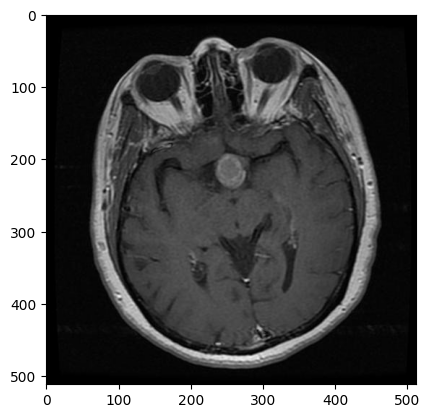

In [42]:
diagnosis(image, bts)
diagnosis(image, trl)

In [ ]:
image = config['data']+'Testing/glioma/Te-gl_0036.jpg'

In [ ]:
diagnosis(image, bts)
diagnosis(image, trl)